In [1647]:
import numpy as np
import pandas as pd
import datetime

import urllib.request, json
import requests
from itertools import chain
import gmplot

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

from matplotlib.pylab import plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Import raw data

In [1345]:
dflarge = pd.read_csv('data.csv')
# convert UTC to EST
dflarge['timestamp'] = dflarge['timestamp'].apply(lambda x : datetime.fromisoformat(x).replace(tzinfo=timezone.utc).astimezone(pytz.timezone("America/New_York")))
# convert timestamp column from str to datetime
dflarge['timestamp'] = dflarge['timestamp'].apply(lambda x : pd.to_datetime(datetime.strptime(str(x)[:-6], '%Y-%m-%d %H:%M:%S')))
# unify device name
dflarge = dflarge.sort_values(by='timestamp').reset_index().rename(columns = {'name_x':'device'})
dflarge.loc[dflarge['device']=='smriti phone','device'] = str("device1")

/Users/rachel/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [1346]:
dflarge.shape

(346887, 29)

In [1649]:
dflarge.groupby('beacon_type').count()

,Unnamed: 0,timestamp,name_x,distance,hashcode,isBlocked,last_seen,manufacturer,rssi,tx_power,...,longitude,accuracy(m),altitude(m),geoid_height(m),speed(m/s),bearing(deg),sat_used,sat_inview,name_y,desc
beacon_type,,,,,,,,,,,,,,,,,,,,,
altbeacon,195,195,195,195,195,195,195,195,195,195,...,195,195,195,0,195,160,195,195,0,0
eddystone_uid,28221,28221,28221,28221,28221,28221,28221,28221,28221,28221,...,28221,28221,28221,0,28219,24987,28139,28221,0,0
eddystone_url,493,493,493,493,493,493,493,493,493,493,...,493,493,493,0,493,492,493,493,0,0
ibeacon,317978,317978,317978,317978,317978,317978,317978,317978,317978,317978,...,317978,317978,317978,0,317936,281598,317130,317978,0,0


In [1347]:
dflarge.head()

,index,Unnamed: 0,timestamp,device,beacon_type,distance,hashcode,isBlocked,last_seen,manufacturer,...,longitude,accuracy(m),altitude(m),geoid_height(m),speed(m/s),bearing(deg),sat_used,sat_inview,name_y,desc
0,346359,346359,2021-09-14 14:22:45,device1,ibeacon,50.990363,-1060113490,False,1628298167545,76,...,-73.986798,9,63.187,NaN,1.02,141.0,18.0,26,NaN,NaN
1,346360,346360,2021-09-14 14:22:48,device1,ibeacon,50.990363,-1060113490,False,1628298167545,76,...,-73.986724,7,55.072,NaN,1.24,109.0,18.0,26,NaN,NaN
2,346361,346361,2021-09-14 14:22:50,device1,ibeacon,50.990363,-1060113490,False,1628298167545,76,...,-73.986652,6,49.960,NaN,1.15,122.0,19.0,26,NaN,NaN
3,346362,346362,2021-09-14 14:22:52,device1,ibeacon,50.448288,-1060113490,False,1628298168647,76,...,-73.986589,6,48.363,NaN,1.20,116.0,19.0,26,NaN,NaN
4,346363,346363,2021-09-14 14:22:53,device1,ibeacon,50.448288,-1060113490,False,1628298168646,76,...,-73.986564,5,47.336,NaN,1.07,114.0,19.0,26,NaN,NaN


# Time-wise metrics

### 1. roughly calculate total time spent

In [1348]:
df_dv1 = dflarge[dflarge['device']=='device1']
df_dv1_duration = df_dv1.groupby(df_dv1.timestamp.dt.date).\
                    agg(start=('timestamp', min), end=('timestamp', max),
                        first=('device', 'first'), last=('device', 'last')
                       )
df_dv1_duration['duration'] = df_dv1_duration['end'] - df_dv1_duration['start']
df_dv1_duration['duration'] = df_dv1_duration['duration'].apply(lambda x : x.total_seconds()/60)

In [1349]:
df_dv3 = dflarge[dflarge['device']=='device3']
df_dv3_duration = df_dv3.groupby(df_dv3.timestamp.dt.date).\
                    agg(start=('timestamp', min), end=('timestamp', max),
                        first=('device', 'first'), last=('device', 'last')
                       )
df_dv3_duration['duration'] = df_dv3_duration['end'] - df_dv3_duration['start']
df_dv3_duration['duration'] = df_dv3_duration['duration'].apply(lambda x : x.total_seconds()/60)

In [1350]:
df_dv4 = dflarge[dflarge['device']=='device4']
df_dv4_duration = df_dv4.groupby(df_dv4.timestamp.dt.date).\
                    agg(start=('timestamp', min), end=('timestamp', max),
                        first=('device', 'first'), last=('device', 'last')
                       )
df_dv4_duration['duration'] = df_dv4_duration['end'] - df_dv4_duration['start']
df_dv4_duration['duration'] = df_dv4_duration['duration'].apply(lambda x : x.total_seconds()/60)

In [1351]:
duration = pd.concat([df_dv1_duration, df_dv3_duration, df_dv4_duration]).\
                        sort_values(by='start').\
                        rename(columns={'first':'device'})
del duration['last']
duration.index.name = 'date'
duration = duration.drop_duplicates()
duration

,start,end,device,duration
date,,,,
2021-09-14,2021-09-14 14:22:45,2021-09-14 14:36:58,device1,14.216667
2021-09-24,2021-09-24 15:18:47,2021-09-24 17:58:15,device1,159.466667
2021-09-24,2021-09-24 19:29:05,2021-09-24 20:21:25,device3,52.333333
2021-09-26,2021-09-26 20:19:26,2021-09-26 20:41:08,device3,21.700000
2021-09-28,2021-09-28 15:42:44,2021-09-28 16:40:48,device4,58.066667
2021-10-02,2021-10-02 20:11:53,2021-10-02 20:45:22,device3,33.483333
2021-10-07,2021-10-07 19:25:21,2021-10-07 19:34:04,device3,8.716667
2021-10-08,2021-10-08 16:36:19,2021-10-08 17:38:04,device1,61.750000
2021-10-09,2021-10-09 16:43:50,2021-10-09 16:49:32,device4,5.700000


In [1352]:
# remove 10 minutes each hour
duration['duration'] = duration['duration'].apply(lambda x :  x - int(x/60)*10)
duration

,start,end,device,duration
date,,,,
2021-09-14,2021-09-14 14:22:45,2021-09-14 14:36:58,device1,14.216667
2021-09-24,2021-09-24 15:18:47,2021-09-24 17:58:15,device1,139.466667
2021-09-24,2021-09-24 19:29:05,2021-09-24 20:21:25,device3,52.333333
2021-09-26,2021-09-26 20:19:26,2021-09-26 20:41:08,device3,21.700000
2021-09-28,2021-09-28 15:42:44,2021-09-28 16:40:48,device4,58.066667
2021-10-02,2021-10-02 20:11:53,2021-10-02 20:45:22,device3,33.483333
2021-10-07,2021-10-07 19:25:21,2021-10-07 19:34:04,device3,8.716667
2021-10-08,2021-10-08 16:36:19,2021-10-08 17:38:04,device1,51.750000
2021-10-09,2021-10-09 16:43:50,2021-10-09 16:49:32,device4,5.700000


In [1353]:
# total time spent on walking (in minute) (roughly, not very accurate, pls refer to the other one below)
duration['duration'].sum(axis=0)/60

48.603888888888896

## 2. time spent on each area

In [1355]:
# import census data 2010
import geopandas as gpd
census2010 = gpd.read_file('https://raw.githubusercontent.com/smriti283/Datasets/main/NYCcensus_exploded.json')

# get coordinates
from shapely.geometry import Point
dflarge['coordinates'] = list(zip(dflarge.longitude, dflarge.latitude))
dflarge['coordinates'] = dflarge['coordinates'].apply(Point)

# convert dataframe to geodataframe
points = gpd.GeoDataFrame(dflarge, geometry='coordinates')

# merge with census zone data
points_all = points
points_all.crs = census2010.crs
df_census_all = gpd.sjoin(points_all, census2010, how='left')
df_census_all = pd.DataFrame(df_census_all)

In [1437]:
def timespent(data, device):
    a = data[data['device']==device].reset_index()  
    
    # split records into parts with the same census_id in the longest consecutive timestamp
    start = 0
    locpar = [start] # partition of locations
    loc = [a['census_id'][start]]

    for i in range(0, len(a)-1):
        if a['census_id'][i] == a['census_id'][i+1]:
            end = i+1
        else:
            start = i+1
            locpar.append(start)
            loc.append(a['census_id'][start])
            
    # calculate durations
    locpardu = []
    for i in range(0, len(locpar)-1):
        locpardu.append((a['timestamp'][locpar[i+1]-1] - a['timestamp'][locpar[i]]).total_seconds()/60)
    locpardu.append((a['timestamp'][len(a)-1] - a['timestamp'][locpar[i+1]]).total_seconds()/60)

    # zip census_id and duration
    b = pd.DataFrame(list(zip(loc,locpardu))).\
                rename(columns={0:'census',1:'duration'})
    
    # add a 10-sec duration for those census_id with only one hit at a time (duration=0)
    b.loc[b['duration']<0.0001,'duration'] = 10/60
    
    # sum up time spent on the same census block
    c = b.groupby('census').sum('duration')
    c['census_id'] = c.index
    c = c.reset_index()
    del c['census']
    
    return c

In [1358]:
df_census_all = df_census_all.rename(columns={'level_0':'level_0_'})
df_census_all['device'] = df_census_all['device'].apply(lambda x :  str(x))

In [1513]:
time_each = pd.merge(
                    pd.merge(timespent(df_census_all, 'device1'),\
                             timespent(df_census_all, 'device3'),\
                             how = 'outer',\
                             on = 'census_id').fillna(0),
                    timespent(df_census_all, 'device4'),
                    how = 'outer',\
                    on = 'census_id'
                    ).fillna(0)
time_each['dur'] = time_each['duration_x'] + time_each['duration_y'] + time_each['duration']
time_each = time_each[['census_id', 'dur']]
time_each

,census_id,dur
0,3,0.183333
1,12,0.550000
2,13,40.900000
3,19,19.183333
4,20,7.416667
...,...,...
125,1200,0.566667
126,1207,3.000000
127,1246,3.366667
128,1248,262.900000


## 3. total time spent

In [1441]:
# total time spent (accurate version)
sum(time_each.dur)/60

42.57694444444444

In [1442]:
# hits per minute
len(dflarge)/sum(time_each.dur)

135.78827873718822

# Data cleaning: remove duplicate records and unwanted columns

## 1. read 300,000 records, reformat timestamp, sort values by timestamp

##### round up 30 seconds

- 00:00:00-00:00:29   to 00:00:00
- 00:00:30-00:00:59   to 00:00:30

In [1362]:
dflarge['speed(m/s)'].describe()

count    346843.000000
mean          1.011760
std           0.525628
min           0.000000
25%           0.850000
50%           1.090000
75%           1.260000
max          17.210000
Name: speed(m/s), dtype: float64

In [1363]:
dflarge[(dflarge['speed(m/s)']>dflarge['speed(m/s)'].quantile(.01))&
        (dflarge['speed(m/s)']<dflarge['speed(m/s)'].quantile(.99))]['speed(m/s)'].mean()

1.1196674833049982

In [1364]:
# https://locatify.com/blog/ble-beacons-no-bull-beacon-review/
# beacon devices boardest coverage 40 meters away

# https://www.healthline.com/health/exercise-fitness/average-walking-speed#average-speed-by-age
# normal females between the age of 20 and 39 walks 1.367 meters per second

# it means, we will be out of the coverage range of the beacon we detected at most 40/1.367=29.26 seconds ago

# so we assume that the signals with the same set of uuid, major and minor are from the same beacon within 30s

In [1365]:
dflarge['timestamp']

0        2021-09-14 14:22:45
1        2021-09-14 14:22:48
2        2021-09-14 14:22:50
3        2021-09-14 14:22:52
4        2021-09-14 14:22:53
                 ...        
346882   2021-11-17 14:12:39
346883   2021-11-17 14:12:39
346884   2021-11-17 14:12:39
346885   2021-11-17 14:12:44
346886   2021-11-17 14:12:44
Name: timestamp, Length: 346887, dtype: datetime64[ns]

In [1366]:
dflarge['timestamp'].dt.floor('.5T')

0        2021-09-14 14:22:30
1        2021-09-14 14:22:30
2        2021-09-14 14:22:30
3        2021-09-14 14:22:30
4        2021-09-14 14:22:30
                 ...        
346882   2021-11-17 14:12:30
346883   2021-11-17 14:12:30
346884   2021-11-17 14:12:30
346885   2021-11-17 14:12:30
346886   2021-11-17 14:12:30
Name: timestamp, Length: 346887, dtype: datetime64[ns]

In [1367]:
dflarge['timestamp'] = dflarge['timestamp'].dt.floor('.5T')

## 2. group data by different types of beacon signals, separate them

In [1368]:
pd.DataFrame(dflarge.groupby('beacon_type').count()['rssi'].sort_values(ascending=False)).rename(columns={'rssi':'count'})

,count
beacon_type,
ibeacon,317978
eddystone_uid,28221
eddystone_url,493
altbeacon,195


In [1369]:
dflarge.columns

Index(['index', 'Unnamed: 0', 'timestamp', 'device', 'beacon_type', 'distance',
       'hashcode', 'isBlocked', 'last_seen', 'manufacturer', 'rssi',
       'tx_power', 'eddystoneUidData', 'major', 'minor', 'uuid', 'type',
       'date time', 'latitude', 'longitude', 'accuracy(m)', 'altitude(m)',
       'geoid_height(m)', 'speed(m/s)', 'bearing(deg)', 'sat_used',
       'sat_inview', 'name_y', 'desc', 'coordinates'],
      dtype='object')

In [1370]:
# ibeacon and altbeacon have uuid, major and minor as identifiers
df1 = dflarge[(dflarge['beacon_type']=='ibeacon')|(dflarge['beacon_type']=='altbeacon')]
# eddystone_uid has eddystoneUidData (including namespace_id and instance_id) as identifiers
df2 = dflarge[(dflarge['beacon_type']=='eddystone_uid')]
# eddystone_url uses url to transmit data
df3 = dflarge[(dflarge['beacon_type']=='eddystone_url')]

## 3. what's in each dataset?

In [1371]:
# NaN(s) for column 'eddystoneUidData'
df1[['uuid','major','minor', 'eddystoneUidData']].head()

,uuid,major,minor,eddystoneUidData
0,2686f39c-bada-4658-854a-a62e7e5e8b8d,1.0,0.0,NaN
1,2686f39c-bada-4658-854a-a62e7e5e8b8d,1.0,0.0,NaN
2,2686f39c-bada-4658-854a-a62e7e5e8b8d,1.0,0.0,NaN
3,2686f39c-bada-4658-854a-a62e7e5e8b8d,1.0,0.0,NaN
4,2686f39c-bada-4658-854a-a62e7e5e8b8d,1.0,0.0,NaN


In [1372]:
# NaN(s) for column 'uuid', 'major', 'minor'
df2[['uuid','major','minor', 'eddystoneUidData']].head()

,uuid,major,minor,eddystoneUidData
2755,NaN,NaN,NaN,"{'instance_id': '0x000054000267', 'namespace_i..."
2756,NaN,NaN,NaN,"{'instance_id': '0x000054000267', 'namespace_i..."
2757,NaN,NaN,NaN,"{'instance_id': '0x000054000267', 'namespace_i..."
2758,NaN,NaN,NaN,"{'instance_id': '0x000054000267', 'namespace_i..."
2759,NaN,NaN,NaN,"{'instance_id': '0x000054000267', 'namespace_i..."


In [1373]:
# NaN(s) for column 'uuid', 'major', 'minor' and 'eddystoneUidData'
df3[['uuid','major','minor', 'eddystoneUidData']].head()

,uuid,major,minor,eddystoneUidData
54435,NaN,NaN,NaN,NaN
54436,NaN,NaN,NaN,NaN
54437,NaN,NaN,NaN,NaN
54440,NaN,NaN,NaN,NaN
54441,NaN,NaN,NaN,NaN


## 4. remove duplicates (type by type)

In [1374]:
newdf1 = df1.drop_duplicates(subset = ['timestamp', 'device', 'major', 'minor', 'uuid'])
newdf2 = df2.drop_duplicates(subset = ['timestamp', 'device', 'eddystoneUidData'])
newdf3 = df3.drop_duplicates(subset = ['timestamp'])
newdflarge = pd.concat([newdf1, newdf2, newdf3]).reset_index()

## 5. remove unwanted columns

In [ ]:
newdflarge = newdflarge[['timestamp', 'device', 'beacon_type',
                         'major', 'minor', 'uuid', 'eddystoneUidData',
                         'rssi', 'tx_power', 'distance',  
                         'latitude', 'longitude', 'speed(m/s)',
                         'manufacturer', 'last_seen']]
                         #'hashcode', 'accuracy(m)', 'bearing(deg)', 'sat_used', 'sat_inview']] #useful or not?

## 6. check the new dataset

In [1377]:
# with 208 unique uuids
# get the uuids from the list, sort them by frequency
uuidFreq = pd.DataFrame(newdflarge.groupby(['uuid'])['timestamp'].count()).\
            rename(columns={'timestamp':'frequency'}).\
            sort_values(by='frequency',ascending=False).reset_index()
uuidFreq

,uuid,frequency
0,50765cb7-d9ea-4e21-99a4-fa879613a492,992
1,5993a94c-7d97-4df7-9abf-e493bfd5d000,969
2,74278bda-b644-4520-8f0c-720eaf059935,769
3,2686f39c-bada-4658-854a-a62e7e5e8b8d,659
4,8a21c76b-74e3-4341-92be-33fcfdefdd63,456
...,...,...
203,8892d497-2507-4fbc-ac6d-e9aefe6e9266,1
204,82a8029d-d537-47f9-84d9-3bbc8052f66b,1
205,7905af11-2899-4115-ab1c-8db67c2176a8,1
206,76d8ae26-3f03-2f99-c934-31f052c5fc80,1


In [1378]:
# with 631 unique euids
# get the eddystone uid from the list, sort them by frequency
euidFreq = pd.DataFrame(newdflarge.groupby(['eddystoneUidData'])['timestamp'].count()).\
            rename(columns={'timestamp':'frequency'}).\
            sort_values(by='frequency',ascending=False).reset_index()
euidFreq

,eddystoneUidData,frequency
0,"{'instance_id': '0xa30051700000', 'namespace_i...",26
1,"{'instance_id': '0x5c9781b82972', 'namespace_i...",24
2,"{'instance_id': '0xa30058700000', 'namespace_i...",23
3,"{'instance_id': '0xa300856d0000', 'namespace_i...",22
4,"{'instance_id': '0xa300816d0000', 'namespace_i...",21
...,...,...
626,"{'instance_id': '0xa300216f0000', 'namespace_i...",1
627,"{'instance_id': '0x0b00e4ce0000', 'namespace_i...",1
628,"{'instance_id': '0xa300236f0000', 'namespace_i...",1
629,"{'instance_id': '0x0b00e4e40000', 'namespace_i...",1


# spatial analysis

## 1. convert to geodataframe

In [1379]:
# converting longitude & latitude to geometry
from shapely.geometry import Point
newdflarge['coordinates'] = list(zip(newdflarge.longitude, newdflarge.latitude))
newdflarge.coordinates = newdflarge.coordinates.apply(Point)
# converting dataframe to geodataframe 
points = gpd.GeoDataFrame(newdflarge, geometry='coordinates')

## 2. import taxi zone and census zone shapefiles

In [1380]:
import geopandas as gpd

<AxesSubplot:>

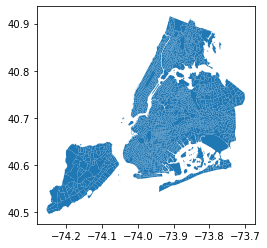

In [1381]:
#taxi blocks
taxi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')

#census blocks
#census = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile') #latest
census2010 = gpd.read_file('https://raw.githubusercontent.com/smriti283/Datasets/main/NYCcensus_exploded.json') #2010 version
census2010.plot(figsize=(4,4))

## 3. merge beacon data with shapefile data

In [1383]:
# merge with taxi zone data

points1 = points
points1.crs = taxi.crs
# spatial join
sjoin_ = gpd.sjoin(points1, taxi, how='left')
# converting geodataframe to dataframe
df_taxi_bd = pd.DataFrame(sjoin_)

In [1384]:
# merge with census zone data

points2 = points
points2.crs = census2010.crs
# spatial join
sjoin_ = gpd.sjoin(points2, census2010, how='left')
# converting geodataframe to dataframe
df_census_bd = pd.DataFrame(sjoin_)

In [1645]:
# 30-second aggregated beacon data with location information in census(2010)-level
df_census_bd.to_csv('beacon30Census10.csv', header='group')

## 4. taxi-zone-level analysis

In [1387]:
fq = df_taxi_bd.groupby('zone').count()[['timestamp']].rename(columns={'timestamp':'beacon_activities'})
fq.head()

,beacon_activities
zone,
Bedford,131
Boerum Hill,205
Brooklyn Heights,79
Bushwick North,5
Bushwick South,56


In [1388]:
taxi_fq = taxi.merge(fq, left_on='zone', right_on='zone', how = 'left').fillna(0)
taxi_fq = taxi_fq[(taxi_fq['borough']=='Manhattan')|(taxi_fq['borough']=='Brooklyn')]
taxi_fq = taxi_fq[['borough', 'zone', 'beacon_activities', 'shape_area', 'geometry']].\
                sort_values(by='beacon_activities', ascending=False)
taxi_fq.head()

,borough,zone,beacon_activities,shape_area,geometry
230,Manhattan,TriBeCa/Civic Center,2165.0,0.000167,"POLYGON ((-74.00932 40.72470, -74.00864 40.724..."
163,Manhattan,Midtown South,1821.0,0.000056,"POLYGON ((-73.98363 40.74394, -73.98407 40.743..."
100,Manhattan,Garment District,1023.0,0.000037,"POLYGON ((-73.98729 40.75045, -73.98777 40.749..."
160,Manhattan,Midtown Center,812.0,0.000072,"POLYGON ((-73.97534 40.75530, -73.97581 40.754..."
161,Manhattan,Midtown East,419.0,0.000048,"POLYGON ((-73.97122 40.75519, -73.97168 40.754..."


/Users/rachel/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/rachel/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 5
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

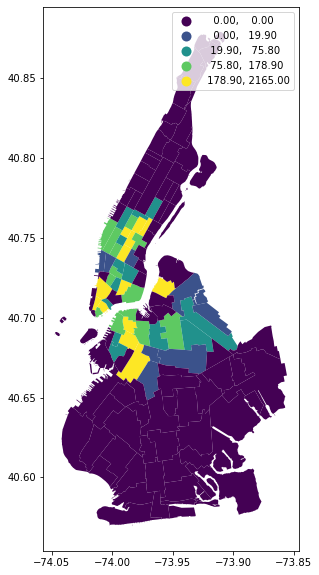

In [1389]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, figsize=(5,10))
taxi_fq.plot(ax=ax, column='beacon_activities', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper right'})

## 5. census-level analysis

### (1) census-level aggregation

- num_unique: number of unique uuids (in each census area)
- num_hits: number of hits (beacon signals) (in each census area)
- duration: time spent (in each census area)
- num_hits_per_min: number of hits per minute (in each census area)

In [1457]:
fq_bd = df_census_bd.groupby('census_id').count()[['timestamp']].\
                    reset_index().rename(columns={'timestamp':'number_of_beacon_devices'})
fq_bd.sort_values(by='number_of_beacon_devices', ascending=False)[0:15]

,census_id,number_of_beacon_devices
44,109,1327
15,55,744
64,147,627
12,34,624
18,61,593
38,101,473
59,141,394
50,122,301
51,124,264
6,23,256


In [1458]:
fq_bs = df_census_all.groupby('census_id').count()[['timestamp']].\
                reset_index().rename(columns={'timestamp':'number_of_beacon_signals'})
fq_bs.sort_values(by='number_of_beacon_signals', ascending=False)[0:15]

,census_id,number_of_beacon_signals
13,34,49254
17,55,42041
68,147,29165
63,141,21865
48,109,19278
21,61,14723
89,773,13881
2,13,10975
81,749,9103
15,53,8420


In [1514]:
# time spent in each area
time_each = time_each.rename(columns={'dur':'duration'})
time_each

,census_id,duration
0,3,0.183333
1,12,0.550000
2,13,40.900000
3,19,19.183333
4,20,7.416667
...,...,...
125,1200,0.566667
126,1207,3.000000
127,1246,3.366667
128,1248,262.900000


In [1529]:
census_bd_bs_time = pd.merge(pd.merge(fq_bs,fq_bd,how='outer',on='census_id').fillna(1),
                             time_each,
                             how = 'outer',
                             on = 'census_id')
census_bd_bs_time['number_of_beacon_signals_per_minute'] = census_bd_bs_time['number_of_beacon_signals']/census_bd_bs_time['duration']
census_bd_bs_time = census_bd_bs_time.sort_values(by='number_of_beacon_signals_per_minute',ascending=False).reset_index()
del census_bd_bs_time['index']

In [1530]:
census_bd_bs_time.head()

,census_id,number_of_beacon_signals,number_of_beacon_devices,duration,number_of_beacon_signals_per_minute
0,55,42041,744.0,33.500000,1254.955224
1,70,756,22.0,0.650000,1163.076923
2,34,49254,624.0,43.233333,1139.259830
3,53,8420,190.0,7.550000,1115.231788
4,107,2810,164.0,3.233333,869.072165


### (2) merge with census geoinfo

In [1547]:
census_bd_bs_time_loc = pd.merge(census_bd_bs_time,
                                 pd.DataFrame(census2010.census_id.unique()).rename(columns={0:'census_id'}),
                                 on = 'census_id',
                                 how = 'right'
                                ).fillna(0)
census_bd_bs_time_loc = pd.merge(census_bd_bs_time_loc,
                                 census2010,
                                 on = 'census_id'
                                )
census_bd_bs_time_loc = census_bd_bs_time_loc[['census_id','NTAName',
                       'number_of_beacon_signals_per_minute', 
                       'number_of_beacon_signals',
                       'number_of_beacon_devices',
                       'duration',
                       'level_0', 'level_1',
                       'OBJECTID', 'CTLabel', 'BoroCode', 'BoroName',
                       'CT2020', 'BoroCT2020', 'NTA2020',
                       'CDTA2020', 'CDTANAME', 'GEOID', 'Shape__Area', 'geometry']]
census_bd_bs_time_loc = census_bd_bs_time_loc[(census_bd_bs_time_loc['BoroName']=='Manhattan')|(census_bd_bs_time_loc['BoroName']=='Brooklyn')]
census_bd_bs_time_loc

,census_id,NTAName,number_of_beacon_signals_per_minute,number_of_beacon_signals,number_of_beacon_devices,duration,level_0,level_1,OBJECTID,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,NTA2020,CDTA2020,CDTANAME,GEOID,Shape__Area,geometry
0,0,The Battery-Governors Island-Ellis Island-Libe...,0.000000,0.0,0.0,0.000000,0,0,1,1,1,Manhattan,000100,1000100,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,1.844391e+06,"POLYGON ((-74.04388 40.69020, -74.04351 40.689..."
1,1,The Battery-Governors Island-Ellis Island-Libe...,0.000000,0.0,0.0,0.000000,0,1,1,1,1,Manhattan,000100,1000100,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,1.844391e+06,"POLYGON ((-74.03995 40.70090, -74.03945 40.700..."
2,2,Chinatown-Two Bridges,0.000000,0.0,0.0,0.000000,1,0,2,2.01,1,Manhattan,000201,1000201,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,9.723121e+05,"POLYGON ((-73.98450 40.70952, -73.98655 40.709..."
3,3,Lower East Side,245.454545,45.0,1.0,0.183333,2,0,3,2.02,1,Manhattan,000202,1000202,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000202,3.315114e+06,"POLYGON ((-73.98364 40.70960, -73.98450 40.709..."
4,4,Lower East Side,0.000000,0.0,0.0,0.000000,2,1,3,2.02,1,Manhattan,000202,1000202,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000202,3.315114e+06,"POLYGON ((-73.98237 40.70555, -73.98246 40.705..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,1572,East New York-City Line,0.000000,0.0,0.0,0.000000,1470,0,1471,1214,3,Brooklyn,121400,3121400,BK0505,BK05,BK05 East New York-Cypress Hills (CD 5 Approxi...,36047121400,1.864054e+06,"POLYGON ((-73.86833 40.66874, -73.86777 40.668..."
1573,1573,East New York-City Line,0.000000,0.0,0.0,0.000000,1471,0,1472,1220,3,Brooklyn,122000,3122000,BK0505,BK05,BK05 East New York-Cypress Hills (CD 5 Approxi...,36047122000,1.148721e+07,"POLYGON ((-73.86270 40.65763, -73.86300 40.657..."
1574,1574,Bedford-Stuyvesant (West),0.000000,0.0,0.0,0.000000,1472,0,1473,1237,3,Brooklyn,123700,3123700,BK0301,BK03,BK03 Bedford-Stuyvesant (CD 3 Approximation),36047123700,3.459462e+06,"POLYGON ((-73.95249 40.69501, -73.95342 40.694..."
1575,1575,Windsor Terrace-South Slope,0.000000,0.0,0.0,0.000000,1473,0,1474,1502,3,Brooklyn,150200,3150200,BK0701,BK07,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,36047150200,3.430774e+06,"POLYGON ((-73.98725 40.66039, -73.98713 40.660..."


### (3) plot the map

In [1549]:
a = gpd.GeoDataFrame(census_bd_bs_time_loc)

/Users/rachel/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/rachel/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

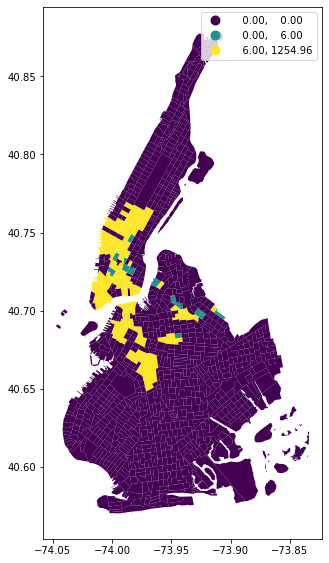

In [1550]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, figsize=(5,10))
a.plot(ax=ax, column='number_of_beacon_signals_per_minute', k=10, 
       scheme='Quantiles', legend=True, legend_kwds={'loc': 'upper right'})

In [1553]:
a = gpd.GeoDataFrame(census_bd_bs_time_loc[census_bd_bs_time_loc['duration']!=0])

<AxesSubplot:>

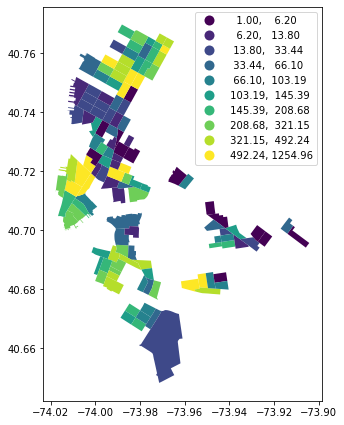

In [1557]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, figsize=(5,10))
a.plot(ax=ax, column='number_of_beacon_signals_per_minute', k=10, 
       scheme='Quantiles', legend=True, legend_kwds={'loc': 'upper right'})

## 6. export census-level data

as we can see, census-level data makes more sense than taxi-zone-level data.

In [1637]:
census_level = census_bd_bs_time_loc.groupby('NTAName').sum()\
                [['duration','number_of_beacon_signals','number_of_beacon_devices']]
census_level = pd.merge(census_level, census_bd_bs_time_loc[['BoroName','NTAName']].drop_duplicates(), on='NTAName', how='left').\
                rename(columns={'BoroName':'Borough','NTAName':'Census Block'})
census_level['Number_of_Beacon_Devices_per_Minute'] = (census_level['number_of_beacon_devices']/census_level['duration']).fillna(0)
census_level['Number_of_Beacon_Signals_per_Minute'] = (census_level['number_of_beacon_signals']/census_level['duration']).fillna(0)
# census_level['city'] = str('New York City')
census_level

,Census Block,duration,number_of_beacon_signals,number_of_beacon_devices,Borough,Number_of_Beacon_Devices_per_Minute,Number_of_Beacon_Signals_per_Minute
0,Barren Island-Floyd Bennett Field,0.000000,0.0,0.0,Brooklyn,0.000000,0.000000
1,Bath Beach,0.000000,0.0,0.0,Brooklyn,0.000000,0.000000
2,Bay Ridge,0.000000,0.0,0.0,Brooklyn,0.000000,0.000000
3,Bedford-Stuyvesant (East),17.250000,1049.0,45.0,Brooklyn,2.608696,60.811594
4,Bedford-Stuyvesant (West),296.616667,9915.0,157.0,Brooklyn,0.529303,33.426982
...,...,...,...,...,...,...,...
103,Washington Heights (North),0.000000,0.0,0.0,Manhattan,0.000000,0.000000
104,Washington Heights (South),0.000000,0.0,0.0,Manhattan,0.000000,0.000000
105,West Village,6.033333,223.0,35.0,Manhattan,5.801105,36.961326
106,Williamsburg,266.266667,746.0,212.0,Brooklyn,0.796194,2.801703


In [1638]:
census_level.to_csv('censusAggregation.csv', header='group')

In [1656]:
census_level.sort_values(by='Number_of_Beacon_Devices_per_Minute', ascending=False)

,Census Block,duration,number_of_beacon_signals,number_of_beacon_devices,Borough,Number_of_Beacon_Devices_per_Minute,Number_of_Beacon_Signals_per_Minute
95,Tribeca-Civic Center,114.216667,114438.0,2151.0,Manhattan,18.832628,1001.937837
44,Fort Greene,8.750000,1019.0,148.0,Brooklyn,16.914286,116.457143
56,Hell's Kitchen,1.916667,1205.0,30.0,Manhattan,15.652174,628.695652
80,Prospect Heights,0.150000,32.0,2.0,Brooklyn,13.333333,213.333333
34,East Midtown-Turtle Bay,31.583333,13777.0,421.0,Manhattan,13.329815,436.211082
...,...,...,...,...,...,...,...
41,Flatbush,0.000000,0.0,0.0,Brooklyn,0.000000,0.000000
37,East New York-New Lots,0.000000,0.0,0.0,Brooklyn,0.000000,0.000000
36,East New York-City Line,0.000000,0.0,0.0,Brooklyn,0.000000,0.000000
35,East New York (North),0.000000,0.0,0.0,Brooklyn,0.000000,0.000000


## 7. clustering based on census-level data

In [1595]:
X = census_bd_bs_time_loc[census_bd_bs_time_loc['number_of_beacon_devices']>0]
X['number_of_beacon_devices_per_minute'] = X.number_of_beacon_devices/X.duration

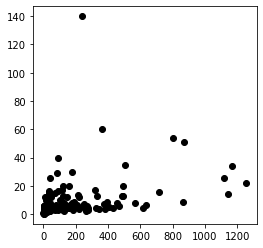

In [1596]:
plt.figure(figsize=(4,4))
plt.scatter(X['number_of_beacon_signals_per_minute'],
            X['number_of_beacon_devices_per_minute'],
            c="k")
plt.show()

In [1597]:
#### silhouette score
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X[['number_of_beacon_signals_per_minute','number_of_beacon_devices_per_minute']])
    #report average Silhouette score
    silhouette_avg = silhouette_score(X[['number_of_beacon_signals_per_minute','number_of_beacon_devices_per_minute']],
                                      cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.7331031550186715
For n_clusters =3, the average silhouette_score is :0.6730427595772501
For n_clusters =4, the average silhouette_score is :0.6171777868096956
For n_clusters =5, the average silhouette_score is :0.62584797847448
For n_clusters =6, the average silhouette_score is :0.6156466945879663
For n_clusters =7, the average silhouette_score is :0.5939113084791645
For n_clusters =8, the average silhouette_score is :0.5925553265138707
For n_clusters =9, the average silhouette_score is :0.5945518593538733
For n_clusters =10, the average silhouette_score is :0.5861024272339863


In [1598]:
from sklearn.cluster import KMeans
km=KMeans(random_state=1,n_clusters=2) #look for 5 clusters; 
res=km.fit(X[['number_of_beacon_signals_per_minute','number_of_beacon_devices_per_minute']]) #train the model
y_t=res.labels_
print(y_t) 

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [1599]:
sum(y_t==1)/len(y_t)

0.13953488372093023

In [1602]:
census_bd_bs_time_loc['CDTANAME'][X['census_id'][y_t==1]]

32      MN03 Lower East Side-Chinatown (CD 3 Equivalent)
34     MN01 Financial District-Tribeca (CD 1 Equivalent)
51      MN03 Lower East Side-Chinatown (CD 3 Equivalent)
53     MN01 Financial District-Tribeca (CD 1 Equivalent)
55     MN01 Financial District-Tribeca (CD 1 Equivalent)
61     MN01 Financial District-Tribeca (CD 1 Equivalent)
70         MN02 Greenwich Village-SoHo (CD 2 Equivalent)
101    MN05 Midtown-Flatiron-Union Square (CD 5 Appro...
107    MN05 Midtown-Flatiron-Union Square (CD 5 Appro...
109    MN05 Midtown-Flatiron-Union Square (CD 5 Appro...
131    MN06 East Midtown-Murray Hill (CD 6 Approximat...
141    MN05 Midtown-Flatiron-Union Square (CD 5 Appro...
146    MN06 East Midtown-Murray Hill (CD 6 Approximat...
150     MN04 Chelsea-Hell's Kitchen (CD 4 Approximation)
800    BK06 Park Slope-Carroll Gardens (CD 6 Approxim...
938         BK03 Bedford-Stuyvesant (CD 3 Approximation)
954         BK03 Bedford-Stuyvesant (CD 3 Approximation)
956         BK03 Bedford-Stuyve